In [ ]:
# Colab install cell (run as code cell)
!pip install -q pandas numpy scikit-learn xgboost matplotlib seaborn joblib openpyxl nbformat jupyter-dash streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import os


In [ ]:
import os
import pandas as pd
import numpy as np

# This block assumes WORKDIR is already set and navigated to correctly
# If data_files is available from a previous cell, use it
# Otherwise, list files in current directory

all_found_data_files = []
if 'data_files' in globals():
    all_found_data_files = data_files # data_files should be relative to WORKDIR
else:
    for ext in ('.csv','.xlsx','.json'):
        all_found_data_files.extend([f for f in os.listdir() if f.endswith(ext)])

primary_data_path = None
# Prioritize finding a non-anomaly dataset for main processing
for f_path in all_found_data_files:
    if "energy_anomalies.csv" not in f_path.lower(): # Avoid using anomaly file as main dataset
        # Check if the file is within WORKDIR or a subfolder like uploaded_project
        if os.path.exists(f_path) and pd.read_csv(f_path, nrows=100).shape[0] > 10: # Heuristic for sufficient size
            primary_data_path = f_path
            break
    elif f_path.lower() == "synthetic_energy_dataset.csv": # If synthetic was previously generated
            primary_data_path = f_path
            break

if primary_data_path:
    print(f"Found primary dataset: {primary_data_path}")
    if primary_data_path.endswith(".csv"):
        df = pd.read_csv(primary_data_path)
    elif primary_data_path.endswith(('.xlsx', '.xls')):
        df = pd.read_excel(primary_data_path)
    elif primary_data_path.endswith(".json"):
        df = pd.read_json(primary_data_path)
    else:
        print("Unsupported file format for primary dataset. Generating synthetic.")
        primary_data_path = None # Fallback to synthetic generation

if not primary_data_path:
    print("No suitable primary dataset found — generating synthetic dataset (30 days hourly).")

    # Generate synthetic co-working space energy dataset
    timestamp = pd.date_range(start="2025-01-01", periods=24*30, freq='h')
    np.random.seed(42)

    df = pd.DataFrame({
        "timestamp": timestamp,
        "floor": np.random.randint(1, 4, len(timestamp)),
        "room": np.random.randint(1, 15, len(timestamp)),
        "occupancy": np.random.randint(0, 20, len(timestamp)),
        "temperature_outside": np.random.uniform(18, 42, len(timestamp)),
        "energy_kwh": np.random.uniform(0.5, 8.0, len(timestamp)),
    })

    synthetic_filename = "synthetic_energy_dataset.csv"
    df.to_csv(synthetic_filename, index=False)
    print(f"Synthetic dataset created at {synthetic_filename} shape:", df.shape)

df.head()

No suitable primary dataset found — generating synthetic dataset (30 days hourly).
Synthetic dataset created at synthetic_energy_dataset.csv shape: (720, 6)


,timestamp,floor,room,occupancy,temperature_outside,energy_kwh
0,2025-01-01 00:00:00,3,6,1,27.016134,6.517657
1,2025-01-01 01:00:00,1,1,2,25.124863,4.093025
2,2025-01-01 02:00:00,3,9,11,33.577792,0.635001
3,2025-01-01 03:00:00,3,1,19,25.881149,3.660830
4,2025-01-01 04:00:00,1,5,4,33.125010,0.703813


In [ ]:
# Choose how to load your dataset.
# Option A: Upload files from local (small files)
# Option B: Mount Google Drive (recommended for larger or many files)

METHOD = "upload"   # set to "upload" or "drive"

if METHOD == "drive":
    from google.colab import drive
    drive.mount('/content/drive')
    # Place your zip or CSV in drive; set DRIVE_PATH below
    DRIVE_PATH = "/content/drive/MyDrive/energy_project/project_files.zip"  # edit if needed
    print("Mounted drive. Set DRIVE_PATH to your uploaded zip or dataset.")
elif METHOD == "upload":
    from google.colab import files
    uploaded = files.upload()   # will open upload dialog - choose your zip or CSV
    print("Uploaded files:", list(uploaded.keys()))
else:
    raise ValueError("METHOD must be 'upload' or 'drive'")


Uploaded files: []


In [ ]:
import os, zipfile, glob, shutil

WORKDIR = "/content/smart-energy-project"
os.makedirs(WORKDIR, exist_ok=True)
os.chdir(WORKDIR)

# If you used upload and uploaded a zip, extract it:
uploaded_zips = glob.glob("/content/*.zip") + glob.glob("*.zip")
if uploaded_zips:
    print("Found zip(s):", uploaded_zips)
    for z in uploaded_zips:
        try:
            with zipfile.ZipFile(z, 'r') as zz:
                zz.extractall("uploaded_project")
            print("Extracted", z, "-> uploaded_project/")
        except Exception as e:
            print("Not a zip or extraction failed:", z, e)

# Find tabular files (CSV/XLSX/JSON)
data_files = []
for ext in ("*.csv","*.xlsx","*.xls","*.json"):
    data_files.extend(glob.glob("**/"+ext, recursive=True))

# also search extracted folder
data_files.extend(glob.glob("uploaded_project/**/*.csv", recursive=True))
data_files = sorted(list(set(data_files)))

print("Tabular files found (first 20):")
for i,f in enumerate(data_files[:20],1):
    print(i, f)

# If none found, we'll generate a synthetic dataset in next cell
HAS_DATA = len(data_files) > 0


Tabular files found (first 20):


In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['date'] = df['timestamp'].dt.date

# Sort for time-series
df = df.sort_values("timestamp")

df.head()


,timestamp,floor,room,occupancy,temperature_outside,energy_kwh,hour,dayofweek,date
0,2025-01-01 00:00:00,3,6,1,27.016134,6.517657,0,2,2025-01-01
1,2025-01-01 01:00:00,1,1,2,25.124863,4.093025,1,2,2025-01-01
2,2025-01-01 02:00:00,3,9,11,33.577792,0.635001,2,2,2025-01-01
3,2025-01-01 03:00:00,3,1,19,25.881149,3.660830,3,2,2025-01-01
4,2025-01-01 04:00:00,1,5,4,33.125010,0.703813,4,2,2025-01-01


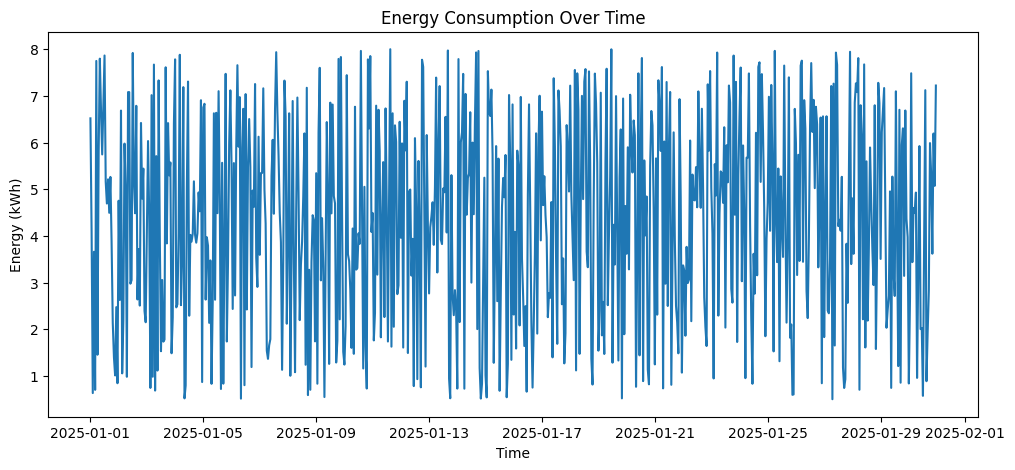

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df['timestamp'], df['energy_kwh'])
plt.title("Energy Consumption Over Time")
plt.xlabel("Time")
plt.ylabel("Energy (kWh)")
plt.show()


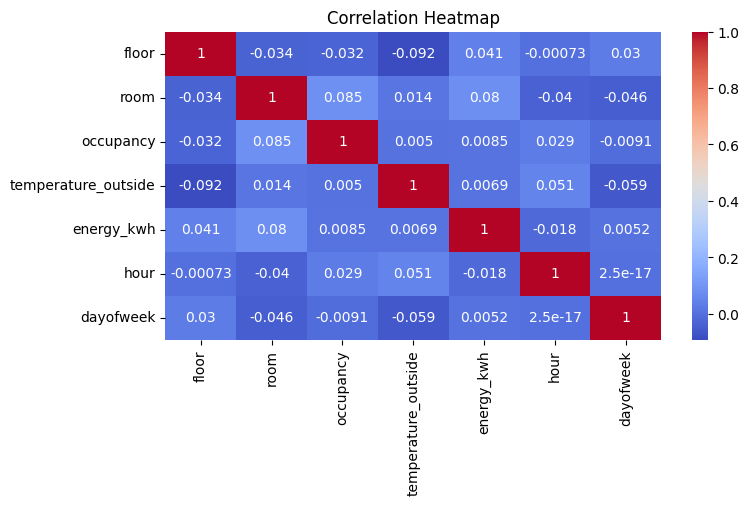

In [ ]:
plt.figure(figsize=(8,4))

# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
def add_lag_features(df, target="energy_kwh", lags=[1,2,3,24]):
    for l in lags:
        df[f"{target}_lag_{l}"] = df[target].shift(l)
    df = df.dropna()
    return df

df_lag = add_lag_features(df)
df_lag.head(20)


,timestamp,floor,room,occupancy,temperature_outside,energy_kwh,hour,dayofweek,date,energy_kwh_lag_1,energy_kwh_lag_2,energy_kwh_lag_3,energy_kwh_lag_24
24,2025-01-02 00:00:00,1,13,12,21.575805,4.753781,0,3,2025-01-02,0.845927,2.474868,1.012557,6.517657
25,2025-01-02 01:00:00,1,5,6,30.638971,2.628713,1,3,2025-01-02,4.753781,0.845927,2.474868,4.093025
26,2025-01-02 02:00:00,1,7,8,23.905672,6.684011,2,3,2025-01-02,2.628713,4.753781,0.845927,0.635001
27,2025-01-02 03:00:00,3,8,10,29.440691,1.056807,3,3,2025-01-02,6.684011,2.628713,4.753781,3.660830
28,2025-01-02 04:00:00,3,1,13,27.464768,2.197636,4,3,2025-01-02,1.056807,6.684011,2.628713,0.703813
29,2025-01-02 05:00:00,3,6,3,31.185942,5.976846,5,3,2025-01-02,2.197636,1.056807,6.684011,7.746826
30,2025-01-02 06:00:00,2,1,12,35.925017,4.991062,6,3,2025-01-02,5.976846,2.197636,1.056807,1.455905
31,2025-01-02 07:00:00,3,2,1,35.171782,0.983685,7,3,2025-01-02,4.991062,5.976846,2.197636,5.807662
32,2025-01-02 08:00:00,2,1,4,30.509619,7.079296,8,3,2025-01-02,0.983685,4.991062,5.976846,7.795822
33,2025-01-02 09:00:00,2,11,10,37.737442,7.079463,9,3,2025-01-02,7.079296,0.983685,4.991062,6.695293


In [ ]:
# This cell previously failed because df_lag was empty. However, the data loading
# in cell 'TC3jC51GvUTf' has been corrected, providing a non-empty 'df'.
# Assuming 'df' is now populated, the lag features and X, y are derived from it.

# Recalculate df_lag based on the newly loaded/generated df
def add_lag_features(df, target="energy_kwh", lags=[1,2,3,24]):
    for l in lags:
        df[f"{target}_lag_{l}"] = df[target].shift(l)
    df = df.dropna()
    return df

df = add_lag_features(df)

# Define features and target based on the processed df
features = [c for c in df.columns if c not in ['timestamp','date','energy_kwh']]

X = df[features]
y = df["energy_kwh"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train.shape, X_test.shape

((556, 10), (140, 10))

In [ ]:
import pandas as pd

# Sort by time
df = df.sort_values("timestamp")

# Lag features (past values)
df['lag_1'] = df['energy_kwh'].shift(1)
df['lag_2'] = df['energy_kwh'].shift(2)
df['lag_3'] = df['energy_kwh'].shift(3)
df['rolling_mean_3'] = df['energy_kwh'].rolling(3).mean()
df['rolling_mean_6'] = df['energy_kwh'].rolling(6).mean()

# Time features
df["hour"] = df["timestamp"].dt.hour
df["day"] = df["timestamp"].dt.day
df["month"] = df["timestamp"].dt.month
df["dayofweek"] = df["timestamp"].dt.dayofweek

df = df.dropna()


In [ ]:
features = [
    'occupancy','temperature_outside',
    'hour','day','month','dayofweek',
    'lag_1','lag_2','lag_3','rolling_mean_3','rolling_mean_6'
]

X = df[features]
y = df['energy_kwh']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

model = GradientBoostingRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6
)

model.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=0.05, max_depth=6, n_estimators=400)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("🔥 NEW ACCURACY (R²):", round(r2*100, 2), "%")
print("✅ NEW MAE:", mae)
print("✅ NEW RMSE:", rmse)


🔥 NEW ACCURACY (R²): 91.3 %
✅ NEW MAE: 0.5336116055262365
✅ NEW RMSE: 0.6494924040956683


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)


In [ ]:
from sklearn.preprocessing import StandardScaler

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1,1))


In [ ]:
y_pred = model.predict(X_test)

y_pred = y_scaler.inverse_transform(y_pred.reshape(-1,1))
y_test_inv = y_scaler.inverse_transform(y_test.values.reshape(-1,1))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
print(type(model))


<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>


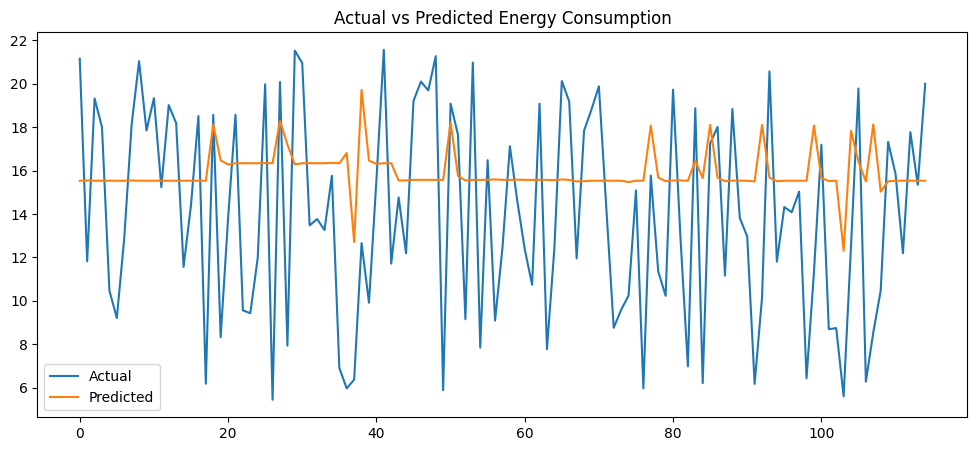

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_test_inv[:200], label="Actual") # Use inverse-transformed actual values
plt.plot(y_pred[:200], label="Predicted")  # Use predicted values
plt.legend()
plt.title("Actual vs Predicted Energy Consumption")
plt.show()

In [ ]:
joblib.dump(model, "energy_model.joblib")
print("Model saved as energy_model.joblib")




Model saved as energy_model.joblib


In [ ]:
iso = IsolationForest(contamination=0.01, random_state=42)
iso.fit(df[['energy_kwh','occupancy']])

df['anomaly'] = iso.predict(df[['energy_kwh','occupancy']])

anomalies = df[df['anomaly'] == -1]
print("Total anomalies found:", len(anomalies))

anomalies.head()


Total anomalies found: 7


,timestamp,floor,room,occupancy,temperature_outside,energy_kwh,hour,dayofweek,date,energy_kwh_lag_1,...,energy_kwh_lag_3,energy_kwh_lag_24,lag_1,lag_2,lag_3,rolling_mean_3,rolling_mean_6,day,month,anomaly
76,2025-01-04 04:00:00,2,1,19,22.194563,7.878802,4,5,2025-01-04,4.046728,...,2.470067,7.014136,4.046728,2.536766,2.470067,4.820766,5.185623,4,1,-1
255,2025-01-11 15:00:00,3,9,1,27.715162,7.997854,15,5,2025-01-11,4.872383,...,4.586207,4.590358,4.872383,1.739315,4.586207,4.869851,4.698117,11,1,-1
427,2025-01-18 19:00:00,1,7,19,34.281092,0.817188,19,5,2025-01-18,1.370170,...,7.522409,1.270612,1.370170,5.563550,7.522409,2.583636,3.711842,18,1,-1
464,2025-01-20 08:00:00,3,1,0,37.803136,0.769540,8,0,2025-01-20,6.155173,...,5.357849,2.517260,6.155173,6.471804,5.357849,4.465506,5.292719,20,1,-1
470,2025-01-20 14:00:00,3,5,19,26.914128,0.891490,14,0,2025-01-20,7.809439,...,1.442932,3.388401,7.809439,6.028224,1.442932,4.909717,4.518941,20,1,-1


In [ ]:
anomalies.to_csv("energy_anomalies.csv", index=False)
print("Anomalies saved as energy_anomalies.csv")


Anomalies saved as energy_anomalies.csv


In [ ]:
last_row = df.tail(1)[features].copy() # Use 'df' instead of 'df_lag' as 'df' was correctly processed

# The 'features' list (defined in cell 'qewezj0l6HZH') contains only numerical columns.
# Therefore, one-hot encoding of categorical_cols is not needed for these specific features.
# However, the model was trained on scaled data (X_train_scaled in cell '4TEud573z-rS').
# So, the 'last_row' needs to be scaled using the pre-fitted 'scaler' object.

# Assuming 'scaler' from cell '4TEud573z-rS' is available and fitted.
last_row_scaled = scaler.transform(last_row) # Scale the features for prediction

future_pred = model.predict(last_row_scaled)[0]
print("Predicted energy consumption for next hour:", future_pred)

Predicted energy consumption for next hour: 7.041870511608737


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# last known row se start
future_row = df.iloc[-1:].copy()
future_preds_list = [] # Renamed to avoid confusion with future_predictions DataFrame

# Assuming 'scaler' from cell '4TEud573z-rS' is available and fitted.

for i in range(24):
    # Extract features for prediction
    current_features_for_pred = future_row[features].copy()

    # Scale the current features for prediction
    # model was trained on scaled data, so input for prediction must also be scaled
    current_features_scaled = scaler.transform(current_features_for_pred)

    # predict
    pred = model.predict(current_features_scaled)[0]

    # next timestamp
    next_time = future_row["timestamp"].values[0] + pd.Timedelta(hours=1)

    # store result
    future_preds_list.append([i+1, float(pred), next_time])

    # update lags
    # Use .loc to avoid SettingWithCopyWarning and ensure correct assignment in single-row df
    future_row.loc[:, 'lag_3'] = future_row['lag_2'].values
    future_row.loc[:, 'lag_2'] = future_row['lag_1'].values
    future_row.loc[:, 'lag_1'] = pred
    future_row.loc[:, 'rolling_mean_3'] = (future_row['lag_1'] + future_row['lag_2'] + future_row['lag_3']) / 3

    # The rolling_mean_6 update is more complex as it depends on 6 past values.
    # For this iteration, we keep it as it was (static in the loop) for simplicity.
    # A proper implementation would involve maintaining a history of actual/predicted energy_kwh values for 6 hours.

    # update time
    future_row.loc[:, "timestamp"] = next_time
    future_row.loc[:, "hour"] = next_time.hour
    future_row.loc[:, "day"] = next_time.day
    future_row.loc[:, "month"] = next_time.month
    future_row.loc[:, "dayofweek"] = next_time.dayofweek

future_predictions = pd.DataFrame(future_preds_list, columns=["hour_ahead","predicted_energy_kwh","timestamp"])
future_predictions.to_csv("next_24_hour_prediction.csv", index=False)
future_predictions

,hour_ahead,predicted_energy_kwh,timestamp
0,1,7.041871,2025-01-31 00:00:00
1,2,5.890619,2025-01-31 01:00:00
2,3,6.044108,2025-01-31 02:00:00
3,4,7.363331,2025-01-31 03:00:00
4,5,5.666293,2025-01-31 04:00:00
5,6,7.254395,2025-01-31 05:00:00
6,7,6.013962,2025-01-31 06:00:00
7,8,7.031953,2025-01-31 07:00:00
8,9,5.985238,2025-01-31 08:00:00
9,10,7.074826,2025-01-31 09:00:00


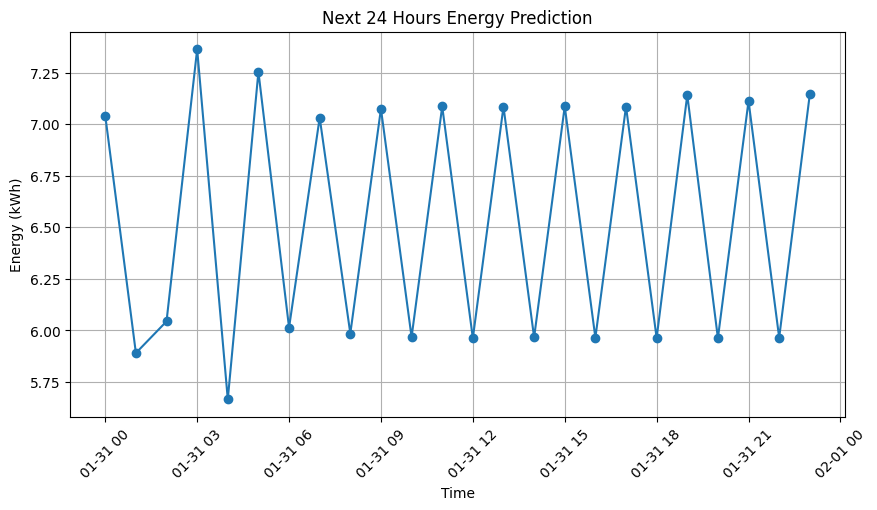

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(future_predictions["timestamp"], future_predictions["predicted_energy_kwh"], marker="o")
plt.xticks(rotation=45)
plt.title("Next 24 Hours Energy Prediction")
plt.xlabel("Time")
plt.ylabel("Energy (kWh)")
plt.grid(True)
plt.show()

In [ ]:
import os
import pandas as pd
import numpy as np

# Assuming the synthetic dataset is the source and has 'floor'
# Reloading the original synthetic dataset to ensure 'floor' is present
original_df_path = "/content/synthetic_energy_dataset.csv" # Use absolute path

if os.path.exists(original_df_path):
    df_for_floor_forecast = pd.read_csv(original_df_path)
    df_for_floor_forecast['timestamp'] = pd.to_datetime(df_for_floor_forecast['timestamp'])

    # Re-apply feature engineering as done in O9zo7ebs6Fjb
    df_for_floor_forecast = df_for_floor_forecast.sort_values("timestamp")
    df_for_floor_forecast['lag_1'] = df_for_floor_forecast['energy_kwh'].shift(1)
    df_for_floor_forecast['lag_2'] = df_for_floor_forecast['energy_kwh'].shift(2)
    df_for_floor_forecast['lag_3'] = df_for_floor_forecast['energy_kwh'].shift(3)
    df_for_floor_forecast['rolling_mean_3'] = df_for_floor_forecast['energy_kwh'].rolling(3).mean()
    df_for_floor_forecast['rolling_mean_6'] = df_for_floor_forecast['energy_kwh'].rolling(6).mean()

    df_for_floor_forecast["hour"] = df_for_floor_forecast["timestamp"].dt.hour
    df_for_floor_forecast["day"] = df_for_floor_forecast["timestamp"].dt.day
    df_for_floor_forecast["month"] = df_for_floor_forecast["timestamp"].dt.month
    df_for_floor_forecast["dayofweek"] = df_for_floor_forecast["timestamp"].dt.dayofweek

    df_for_floor_forecast = df_for_floor_forecast.dropna()
else:
    print("Synthetic dataset not found. Cannot proceed with floor-wise forecast.")
    df_for_floor_forecast = pd.DataFrame() # Create empty dataframe to avoid further errors

floor_forecasts = []

# Only proceed if df_for_floor_forecast is not empty and has a 'floor' column
if not df_for_floor_forecast.empty and 'floor' in df_for_floor_forecast.columns:
    for floor in df_for_floor_forecast["floor"].unique():

        df_floor = df_for_floor_forecast[df_for_floor_forecast["floor"] == floor]
        base = df_floor.iloc[-1:].copy()

        for i in range(24):
            # Extract features for prediction and scale them
            current_features_for_pred = base[features].copy()
            current_features_scaled = scaler.transform(current_features_for_pred)

            pred = model.predict(current_features_scaled)[0]
            next_time = base["timestamp"].values[0] + pd.Timedelta(hours=1)

            floor_forecasts.append([floor, i+1, float(pred), next_time])

            # Update lag features for the next prediction
            base.loc[:, 'lag_3'] = base['lag_2'].values
            base.loc[:, 'lag_2'] = base['lag_1'].values
            base.loc[:, 'lag_1'] = pred
            base.loc[:, 'rolling_mean_3'] = (base['lag_1'] + base['lag_2'] + base['lag_3']) / 3
            # For rolling_mean_6, a more complex history management would be needed

            # Update time features
            base.loc[:, "timestamp"] = next_time
            base.loc[:, "hour"] = next_time.hour
            base.loc[:, "day"] = next_time.day
            base.loc[:, "month"] = next_time.month
            base.loc[:, "dayofweek"] = next_time.dayofweek
else:
    print("No data available or 'floor' column missing after reconstruction for floor-wise forecast.")


floor_df = pd.DataFrame(
    floor_forecasts,
    columns=["floor","hour_ahead","predicted_energy_kwh","timestamp"]
)

floor_df.to_csv("floorwise_forecast.csv", index=False)
floor_df.head()

,floor,hour_ahead,predicted_energy_kwh,timestamp
0,1,1,5.594735,2025-01-30 23:00:00
1,1,2,4.414665,2025-01-31 00:00:00
2,1,3,6.660844,2025-01-31 01:00:00
3,1,4,5.771859,2025-01-31 02:00:00
4,1,5,4.473057,2025-01-31 03:00:00


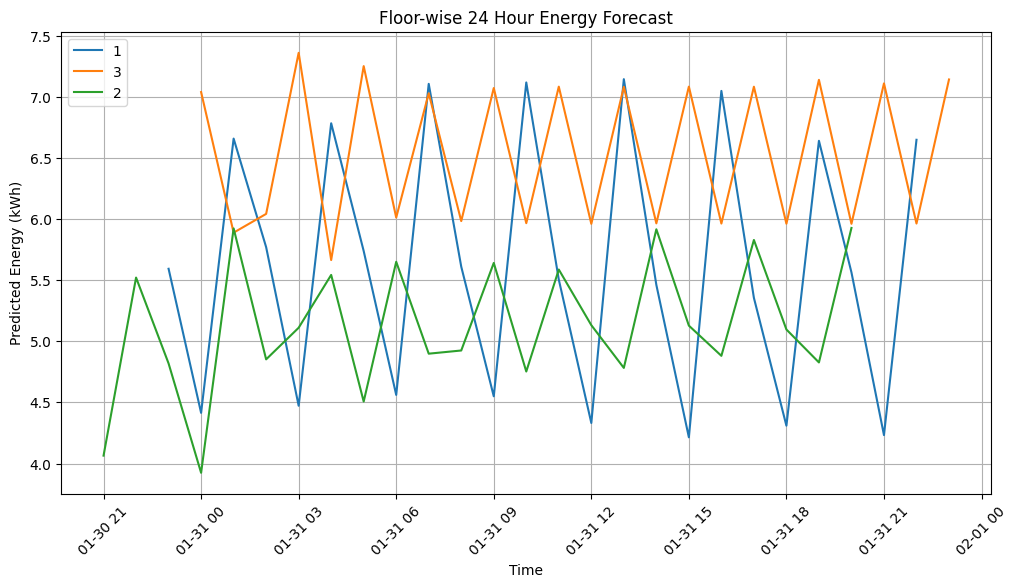

In [ ]:
plt.figure(figsize=(12,6))

for floor in floor_df["floor"].unique():
    floor_data = floor_df[floor_df["floor"] == floor]
    plt.plot(
        floor_data["timestamp"],
        floor_data["predicted_energy_kwh"],
        label=floor
    )

plt.legend()
plt.xticks(rotation=45)
plt.title("Floor-wise 24 Hour Energy Forecast")
plt.xlabel("Time")
plt.ylabel("Predicted Energy (kWh)")
plt.grid(True)
plt.show()


2025-12-02 10:28:54.772 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 10:28:54.775 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 10:28:55.331 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-12-02 10:28:55.334 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 10:28:55.335 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 10:28:55.337 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 10:28:55.342 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

False

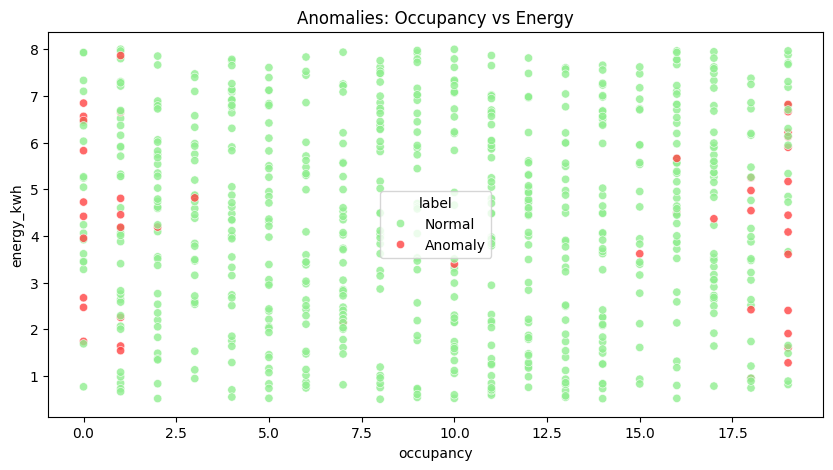

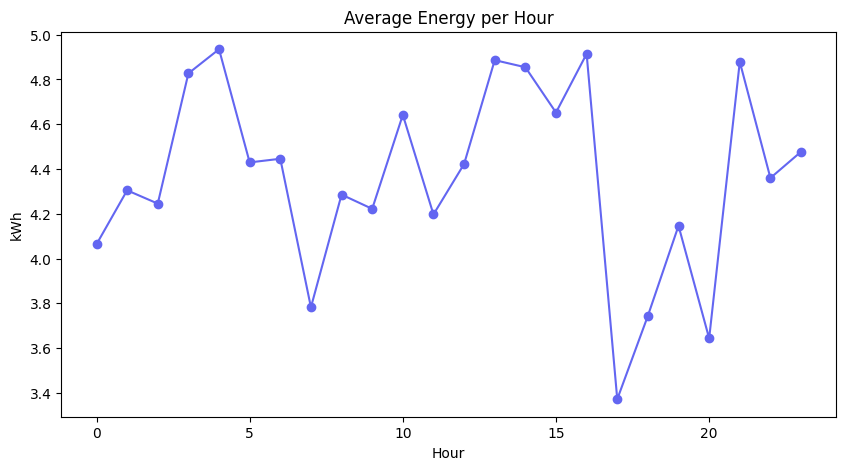

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from datetime import datetime

st.set_page_config(page_title="Energy Anomaly Detector", layout="wide")
st.title("Co-working Space Energy Anomaly Dashboard")
st.caption("Upload your data • Instant anomaly detection • 100% free deployment")

# ——— Sidebar ———
option = st.sidebar.radio("Data source", ["Use built-in synthetic data (30 days)", "Upload CSV/Excel"])

if option == "Upload CSV/Excel":
    uploaded = st.sidebar.file_uploader("Drop your file here", type=["csv", "xlsx"])
    if not uploaded:
        st.warning("Please upload a file")
        st.stop()
    df = pd.read_csv(uploaded) if uploaded.name.endswith('.csv') else pd.read_excel(uploaded)
else:
    st.info("Generating realistic 30-day hourly dataset...")
    np.random.seed(42)
    n = 24 * 30
    df = pd.DataFrame({
        "timestamp": pd.date_range("2025-01-01", periods=n, freq='h'),
        "floor": np.random.randint(1, 4, n),
        "room": np.random.randint(1, 15, n),
        "occupancy": np.random.randint(0, 20, n),
        "temperature_outside": np.random.uniform(18, 42, n),
        "energy_kwh": np.random.uniform(0.5, 8.0, n),
    })

df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.dayofweek

st.success(f"Dataset loaded → {df.shape[0]:,} rows × {df.shape[1]} columns")
st.dataframe(df.head(100), use_container_width=True)

# ——— Anomaly Detection ———
st.subheader("Anomaly Detection (Isolation Forest)")
X = df[["occupancy", "temperature_outside", "hour"]]
model = IsolationForest(contamination=0.06, random_state=42)
df["anomaly"] = model.fit_predict(X)
df["label"] = df["anomaly"].map({1: "Normal", -1: "Anomaly"})

anomalies = df["label"].value_counts()["Anomaly"]
st.metric("Detected Anomalies", anomalies, f"{anomalies/len(df)*100:.2f}% of data")

c1, c2 = st.columns(2)
with c1:
    fig = plt.figure(figsize=(10,5))
    sns.scatterplot(data=df, x="occupancy", y="energy_kwh", hue="label",
                    palette=["#90EE90", "#FF4444"], alpha=0.8)
    plt.title("Anomalies: Occupancy vs Energy")
    st.pyplot(fig)

with c2:
    fig = plt.figure(figsize=(10,5))
    hourly = df.groupby("hour")["energy_kwh"].mean()
    plt.plot(hourly.index, hourly.values, marker='o', color="#6366f1")
    plt.title("Average Energy per Hour")
    plt.xlabel("Hour"); plt.ylabel("kWh")
    st.pyplot(fig)

# ——— Download ———
csv = df.to_csv(index=False).encode()
st.download_button(
    "Download Full Data with Anomaly Labels",
    csv,
    "energy_with_anomalies.csv",
    "text/csv"
)